In [1]:
import numpy as np
import cv2, random, sys, os, glob
from itertools import chain

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

from PIL import Image
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model

In [2]:
from shutil import copyfile
copyfile(src = "../input/facedataset/FUNC_script.py", dst = "../working/FUNC_script.py")
from FUNC_script import *

In [3]:
# Read Images (160x160x3)
def load_img(path, resize=None):
    img= Image.open(path)
    img= img.convert('RGB')
    if resize is not None:
        img= img.resize((resize, resize))
    return np.asarray(img)

### CONFIG

In [4]:
%%capture

totalSubjects= 5
mask= load_img('../input/facedataset/binary_glass_mask2.jpg')/255
imgDir= '../input/facedataset/ORL_jpg/ORL_jpg/ORL_jpg/'
# Load FaceNet Model
model = load_model('../input/face-net-keras-model/facenet_keras.h5', compile= False)
model.trainable= False

# (index(0)==legitimate)
# (index((totalSubjects-1))== Adversarial)
subjects= ['s12', 's33', 's27', 's06', 's01'] #['s33', 's12', 's27', 's06', 's26']
subjectLabels=[]
subjectsDict= {k:[] for k in subjects}
target= subjects[0]

2022-01-19 05:28:56.604653: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 05:28:56.719938: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 05:28:56.720667: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-19 05:28:56.721837: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [5]:
totSample=0
for sam in subjects:
    for path in glob.glob(imgDir+sam+'/*'):
        img= load_img(path, resize=160)
        img= model.predict(img[np.newaxis, :, :, :]/255.0)[0]
        subjectsDict[sam].append(img)
        subjectLabels.append(subjects.index(sam))
        totSample+=1
totSample

2022-01-19 05:29:03.831521: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-01-19 05:29:06.221703: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


50

In [6]:
flattened = np.array([val for sublist in list(subjectsDict.values()) for val in sublist])

pca= PCA(n_components=2)
x= pca.fit_transform(flattened)

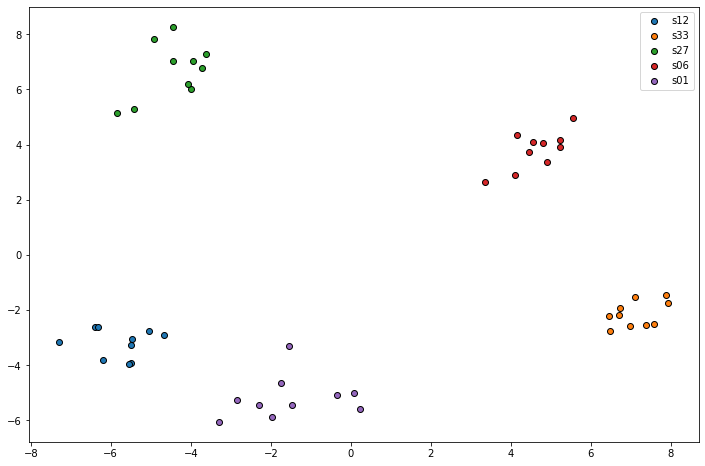

In [7]:
plt.figure(figsize= (12, 8))
for i in range(totalSubjects):
    plt.scatter(x[i*10:(i+1)*10, 0], x[i*10:(i+1)*10, 1], edgecolors='k', label=subjects[i])
    plt.legend()
plt.show()

In [8]:
flattened.shape, len(subjectLabels)

((50, 128), 50)

In [9]:
totalSubjects

5

In [10]:
from sklearn.cluster import KMeans
class kMeansModel:
    def __init__(self, n_class):
        self.n_class=n_class
        self.model= KMeans(n_clusters=self.n_class, random_state=0)
    def fit(self, data):
        self.model.fit(data)
        self.centers= self.model.cluster_centers_
        return self.model.labels_
    def predict(self, data, th=15):
        res=[]
        for d in data:
            arr= np.linalg.norm(self.centers-d, axis=1)
            #print(arr)
            if arr.min()<=th:
                ind= np.where(arr==arr.min())[0][0]
                res.append(ind)
            else:
                res.append(-1)
        return np.array(res)        

In [11]:
KMEANS= kMeansModel(totalSubjects)
KMEANS.fit(flattened)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0], dtype=int32)

### Adversarial Centroid

In [12]:
# Data  Loading
def load_data(path):
    X=[]
    for i, sample in enumerate(path):
        image= load_img(sample)
        image = cv2.resize(image, (160, 160))
        X.append(image/255.0)
    return np.array(X)

# Loss
def loss_object(pred, label, delta):
    # Loss= euclidean distance + Delta_x pixel Variance
    dist= Euclidean_dist(pred, label)
#     print(dist)
#     print(tf.norm(label - pred, axis=-1))
    variance= Sample_variance(delta)
    Loss= tf.math.add(tf.cast(dist, variance.dtype), variance)
    return Loss

def back_propagate(model, X, mask, delta_x, Xc):
    with tf.GradientTape() as g:
        g.watch(delta_x)
        X_batch= Generate_sample(X, delta_x, mask)
        feature= model(X_batch)
        loss= loss_object(pred= feature, label= Xc, delta= delta_x)
    # Get the gradients of the loss w.r.t to the input image.
    gradient = g.gradient(loss, delta_x)
    return gradient, tf.reduce_mean(loss).numpy()

In [13]:
# tragetImages= load_data(glob.glob(imgDir+target+'/*'))
# tragetFeature= model.predict(tragetImages)

advImages= load_data(glob.glob(imgDir+subjects[-1]+'/*'))
advFeature= model.predict(advImages)
Delta= np.random.uniform(low=0.0, high=1.0, size=advImages.shape) #Scale(0-1)
advRefFeature= Generate_target(advFeature[3], batch_size=advImages.shape[0])
advImages.shape, Delta.shape, advRefFeature.shape, advFeature.shape

((10, 160, 160, 3), (10, 160, 160, 3), (10, 128), (10, 128))

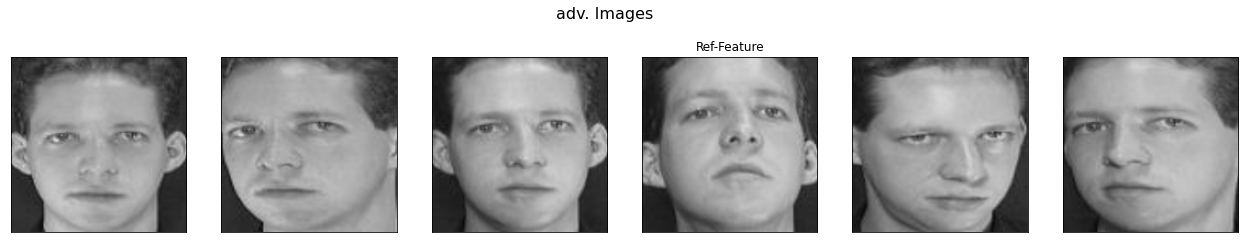

In [14]:
fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(advImages[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
    if i==3:
        ax[i].title.set_text('Ref-Feature')
plt.show()

In [15]:
Delta.shape

(10, 160, 160, 3)

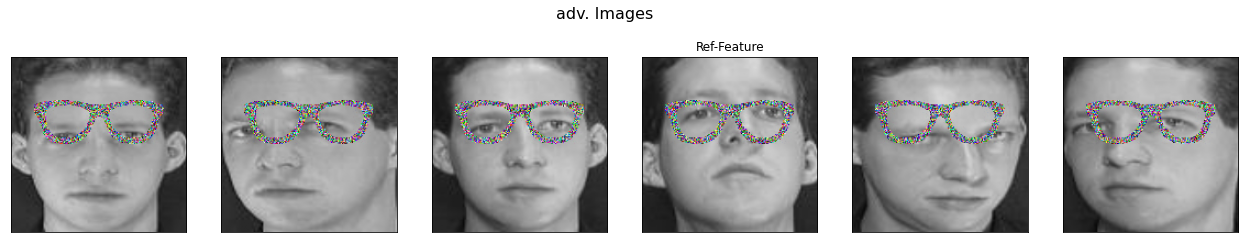

In [16]:
advImagesShow= ((advImages)*(1-mask))+ (Delta*mask)

fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(advImagesShow[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
    if i==3:
        ax[i].title.set_text('Ref-Feature')
plt.show()

In [17]:
# Tf Variables
advImages= tf.Variable(advImages, dtype=tf.float64)
Delta= tf.Variable(Delta, dtype=tf.float64)
mask= tf.Variable(mask, dtype=tf.float64)
advRefFeature= tf.Variable(advRefFeature)

In [18]:
epoch= 400
Lambda= 0.2
for ep  in range(epoch+1):
    grad, loss= back_propagate(model, advImages, mask, Delta, advRefFeature)
    # Gradient step
    Delta= Delta - Lambda*grad
    if ep%10 == 0:
        print('Epoch: {}   Loss: {:.3f}'.format((ep), loss))

Epoch: 0   Loss: 171.974
Epoch: 10   Loss: 158.354
Epoch: 20   Loss: 147.218
Epoch: 30   Loss: 136.852
Epoch: 40   Loss: 126.958
Epoch: 50   Loss: 117.415
Epoch: 60   Loss: 108.167
Epoch: 70   Loss: 99.237
Epoch: 80   Loss: 90.669
Epoch: 90   Loss: 82.407
Epoch: 100   Loss: 74.492
Epoch: 110   Loss: 66.972
Epoch: 120   Loss: 59.875
Epoch: 130   Loss: 53.232
Epoch: 140   Loss: 47.003
Epoch: 150   Loss: 41.325
Epoch: 160   Loss: 36.223
Epoch: 170   Loss: 31.639
Epoch: 180   Loss: 27.650
Epoch: 190   Loss: 24.278
Epoch: 200   Loss: 21.368
Epoch: 210   Loss: 19.034
Epoch: 220   Loss: 17.084
Epoch: 230   Loss: 15.461
Epoch: 240   Loss: 14.187
Epoch: 250   Loss: 13.058
Epoch: 260   Loss: 12.326
Epoch: 270   Loss: 11.422
Epoch: 280   Loss: 10.818
Epoch: 290   Loss: 10.333
Epoch: 300   Loss: 9.950
Epoch: 310   Loss: 9.711
Epoch: 320   Loss: 9.353
Epoch: 330   Loss: 9.101
Epoch: 340   Loss: 8.881
Epoch: 350   Loss: 8.600
Epoch: 360   Loss: 8.439
Epoch: 370   Loss: 8.352
Epoch: 380   Loss: 8.322

In [19]:
subjects.append('deltaAdvCentroid')
subjectsDict['deltaAdvCentroid']= model.predict(Generate_sample(advImages, Delta, mask))
subjectsDict['deltaAdvCentroid'].shape

(10, 128)

In [20]:
flattened= np.vstack((flattened, subjectsDict['deltaAdvCentroid']))

pca= PCA(n_components=2)
x= pca.fit_transform(flattened)
x.shape

(60, 2)

In [21]:
KMEANS.predict(flattened)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

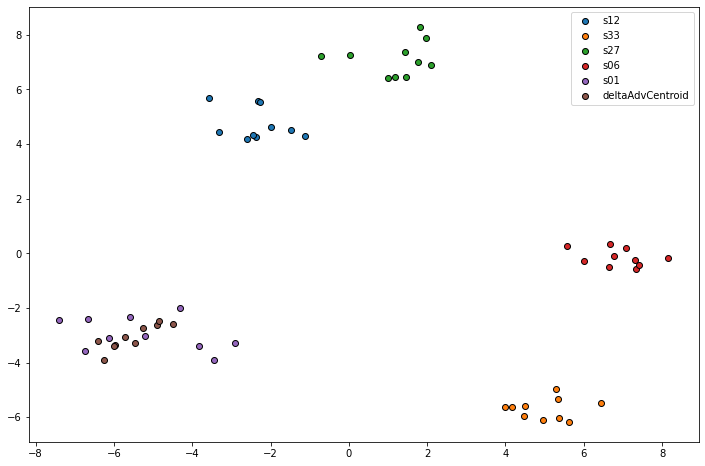

In [22]:
plt.figure(figsize= (12, 8))
for i in range(totalSubjects+1):
    plt.scatter(x[i*10:(i+1)*10, 0], x[i*10:(i+1)*10, 1], edgecolors='k', label=subjects[i])
    plt.legend()
plt.show()

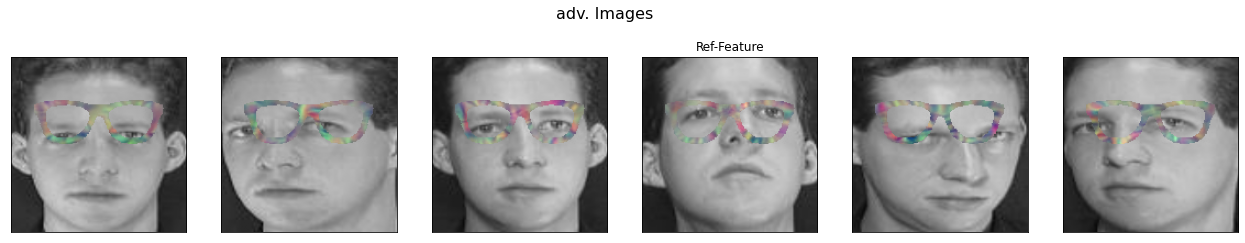

In [23]:
advImagesShow0= ((advImages)*(1-mask))+ (Delta*mask)

fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(advImagesShow0[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
    if i==3:
        ax[i].title.set_text('Ref-Feature')
plt.show()

### Target Att....


In [24]:
tragetImages= load_data(glob.glob(imgDir+target+'/*'))
tragetFeature= (model.predict(tragetImages))
targetRefFeature= Generate_target(np.mean(tragetFeature, axis=0), batch_size=tragetImages.shape[0])
tragetImages.shape, tragetFeature.shape

# advImages= load_data(glob.glob(imgDir+subjects[-1]+'/*'))
# advFeature= model.predict(advImages)
# Delta= np.random.uniform(low=0.0, high=1.0, size=advImages.shape) #Scale(0-1)
# advRefFeature= Generate_target(advFeature[5], batch_size=advImages.shape[0])
# advImages.shape, Delta.shape, advRefFeature.shape, advFeature.shape

((10, 160, 160, 3), (10, 128))

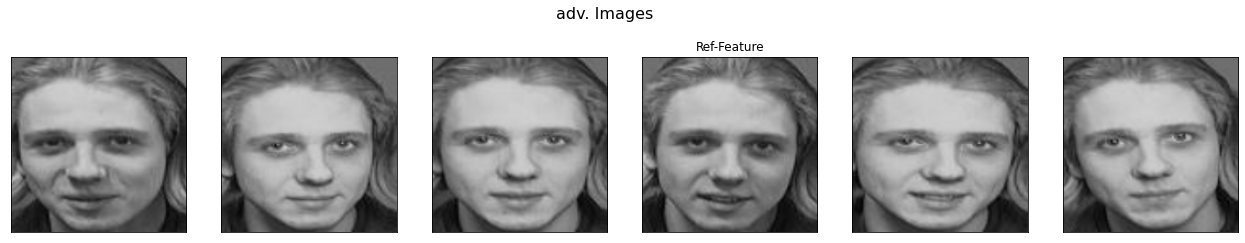

In [25]:
fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images", size= 16)
for i in range(6):
    ax[i].imshow(tragetImages[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
    if i==3:
        ax[i].title.set_text('Ref-Feature')
plt.show()

In [26]:
epoch= int(400 *4.5)
Lambda= 0.014
for ep  in range(epoch):
    grad, loss= back_propagate(model, advImages, mask, Delta, tragetFeature)
    # Gradient step
    Delta= Delta - Lambda*grad
    if ep%20 == 0:
        print('Epoch: {}   Loss: {:.3f}'.format((ep), loss))

Epoch: 0   Loss: 17.441
Epoch: 20   Loss: 15.895
Epoch: 40   Loss: 14.848
Epoch: 60   Loss: 14.113
Epoch: 80   Loss: 13.582
Epoch: 100   Loss: 13.199
Epoch: 120   Loss: 12.892
Epoch: 140   Loss: 12.641
Epoch: 160   Loss: 12.444
Epoch: 180   Loss: 12.279
Epoch: 200   Loss: 12.139
Epoch: 220   Loss: 12.018
Epoch: 240   Loss: 11.914
Epoch: 260   Loss: 11.825
Epoch: 280   Loss: 11.745
Epoch: 300   Loss: 11.671
Epoch: 320   Loss: 11.603
Epoch: 340   Loss: 11.541
Epoch: 360   Loss: 11.485
Epoch: 380   Loss: 11.430
Epoch: 400   Loss: 11.379
Epoch: 420   Loss: 11.330
Epoch: 440   Loss: 11.283
Epoch: 460   Loss: 11.240
Epoch: 480   Loss: 11.199
Epoch: 500   Loss: 11.161
Epoch: 520   Loss: 11.124
Epoch: 540   Loss: 11.089
Epoch: 560   Loss: 11.056
Epoch: 580   Loss: 11.023
Epoch: 600   Loss: 10.991
Epoch: 620   Loss: 10.961
Epoch: 640   Loss: 10.933
Epoch: 660   Loss: 10.905
Epoch: 680   Loss: 10.879
Epoch: 700   Loss: 10.854
Epoch: 720   Loss: 10.830
Epoch: 740   Loss: 10.807
Epoch: 760   Loss:

In [27]:
subjects.append('deltaTarget')
subjectsDict['deltaTarget']= model.predict(Generate_sample(advImages, Delta, mask))
subjectsDict['deltaTarget'].shape

(10, 128)

In [28]:
flattened= np.vstack((flattened, subjectsDict['deltaTarget']))

pca= PCA(n_components=2)
x= pca.fit_transform(flattened)
x.shape

(70, 2)

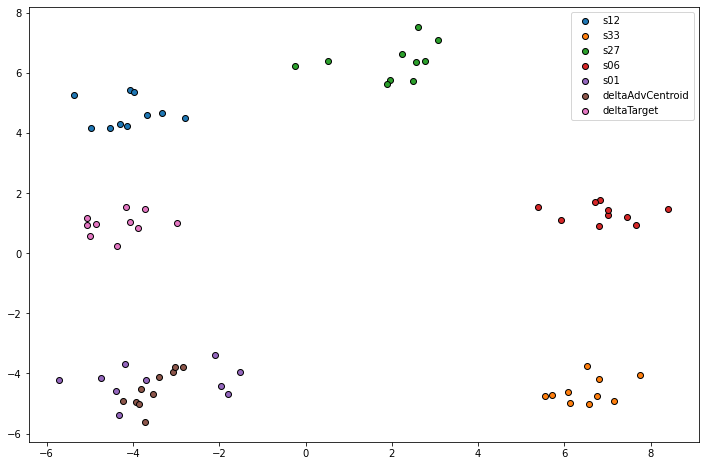

In [29]:
plt.figure(figsize= (12, 8))
for i in range(totalSubjects+2):
    plt.scatter(x[i*10:(i+1)*10, 0], x[i*10:(i+1)*10, 1], edgecolors='k', label=subjects[i])
    plt.legend()
plt.show()

In [30]:
KMEANS.predict(flattened)

array([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 4, 4, 4, 4,
       4, 4, 4, 4])

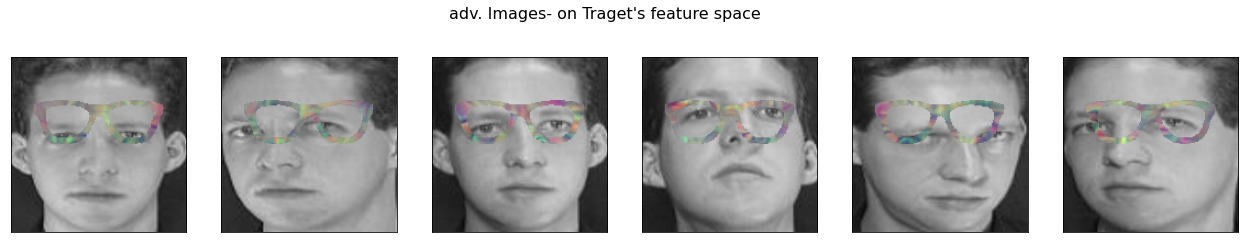

In [31]:
advImagesShow1= ((advImages)*(1-mask))+ (Delta*mask)

fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images- on Traget's feature space", size= 16)
for i in range(6):
    ax[i].imshow(advImagesShow1[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
plt.show()

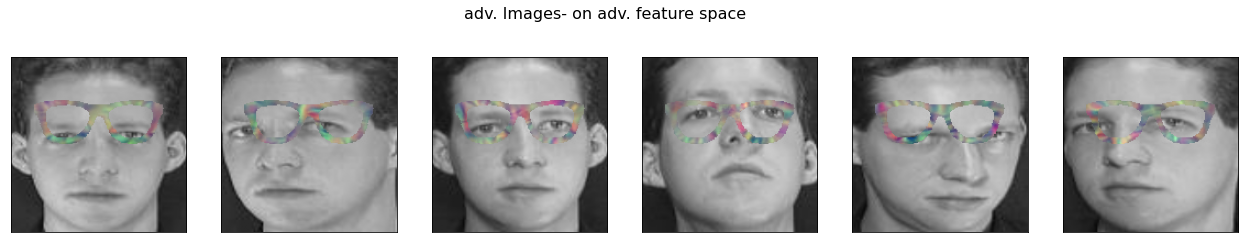

In [32]:
fig, ax= plt.subplots(1, 6, figsize=(22, 4))
fig.suptitle("adv. Images- on adv. feature space", size= 16)
for i in range(6):
    ax[i].imshow(advImagesShow0[i])
    ax[i].set_yticks([]); ax[i].set_xticks([])
plt.show()